# Running linear models on DEA indices using Sentinel

**Background:** This document presents an example of applying a linear model to analyse Landsat data extracted from Digital Earth Australia (DEA) to make inferences about physical processes. Here we are testing the rate of decline in vegetation condition during the dry season in NW Australia. Rainfall in this part of Australia is highly seasonal. During the dry season (April to October) there is very little rain and we assume that soil moisture declines throughout.

A common approach for assessing the likelihood of vegetation being dependent on groundwater is applying the 'green island' principle. This involves inferring gorudnwater use from vegetation that maintains higher condition during dry periods. In our area of interest, we expect that vegetation condition will decline much more rapidly in vegetation communities that are wholly reliant on surface water compared to communities that access groundwater (i.e. groundwater dependent ecosystems). We use NDVI as a proxy for vegetation condition.


**What does this document do?**

- Retrieve Landsat data for temporal and spatial extents
- Calculate NDVI and groupby months
- Demonstrate how to build a linear model to analyse the rate of decay in NDVI throughout the dry season
- Plot linear model parameters and use spatial patterns to infer distribuition of potential GDEs

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: June 2019

**Authors**: Neil Symington, Robbi Bishop-Taylor, Bex Dunn

## Retrieving Landsat data
Here we import data Landsat data from the DEA. In our experience using the larger number of observations decreases our signal-to-noise ration and thus enables us to resolve landscape features at a higher resolution. Hence, for the actual data product we used the entire landsat archive and ran the processing through the raijin supercomputer.  However for this example we will only consider data from 2009-2019 from landsat 8.

### Import modules

In [2]:
%matplotlib inline
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
import calendar
import numpy as np
import xarray as xr

sys.path.append('/home/547/pxk547/JupyterNotebooks/dea-notebooks/10_Scripts/')
import DEADataHandling, DEAPlotting

# Dictoinary for mapping month number to months names 
mnths =dict((k,v) for k,v in enumerate(calendar.month_name) if k!= 0)


In [3]:
# Connect to a datacube
dc = datacube.Datacube(app='LinearModels')


In [4]:

def linregress_3D(x, y):
    """
    
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    """ 
    # Ensure that the data are properly aligned to each other. 
    x,y = xr.align(x,y)

    
    #Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='month')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

def regression_pixel_drill_ndvi(x, y, ax, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndvi_pt = ndvi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndvi_dry.month.values
    
    ax.scatter(months, ndvi_pt, **scatter_kwargs)
    
    # Get the slope and intercepth
    
    slope_ = slope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = intercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)
    
def regression_pixel_drill_ndmi(x, y, ax, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndmi_pt = ndmi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndmi_dry.month.values
    
    ax.scatter(months, ndmi_pt, **scatter_kwargs)
    
    slope_ = NDMIslope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = NDMIintercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)
    

In [5]:
# Create spatial and temporal query


query = {'lat': (-19.786, -19.7365),
         'lon': (145.35, 145.40),
         'time':('2009-01-01', '2019-01-10')}

# Define query coordinate reference system

query['crs'] = 'EPSG:4326'
query['output_crs'] = 'EPSG:28355'
query['resolution'] = (10.,10.)


### Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

In [6]:
# Load data for the specified query extent using `dc.load`:
bands_of_interest = ['nbar_blue', 
                     'nbar_green', 
                     'nbar_red', 
                     'nbar_red_edge_1',
                     'nbar_red_edge_2',
                     'nbar_nir_1',
                     'nbar_nir_2',
                     'nbar_swir_2',
                     'nbar_swir_3'
                    ]
ds = dc.load(product='s2a_ard_granule', group_by='solar_day', 
                  measurements = bands_of_interest, **query)
ds

<xarray.Dataset>
Dimensions:          (time: 102, x: 530, y: 554)
Coordinates:
  * time             (time) datetime64[ns] 2015-10-22T00:27:22.027000 ... 2019-01-04T00:27:01.024000
  * y                (y) float64 7.811e+06 7.811e+06 ... 7.817e+06 7.817e+06
  * x                (x) float64 3.271e+05 3.271e+05 ... 3.324e+05 3.324e+05
Data variables:
    nbar_blue        (time, y, x) int16 612 543 603 573 613 ... 610 560 622 694
    nbar_green       (time, y, x) int16 758 704 732 743 726 ... 816 766 810 889
    nbar_red         (time, y, x) int16 1052 948 1102 1020 ... 936 932 970 1097
    nbar_red_edge_1  (time, y, x) int16 1384 1270 1270 1293 ... 1286 1286 1362
    nbar_red_edge_2  (time, y, x) int16 1547 1492 1492 1494 ... 1814 1814 1846
    nbar_nir_1       (time, y, x) int16 1762 1865 1806 1766 ... 2234 2375 2288
    nbar_nir_2       (time, y, x) int16 2028 1960 1960 1965 ... 2382 2382 2393
    nbar_swir_2      (time, y, x) int16 3207 2890 2890 2820 ... 2617 2617 2705
    nbar_swir_3

## Adding code in to extract cloud free data only (from Bex's stacked plot script)

In [7]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ClearSentinel_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query, bands_of_interest=bands_of_interest, masked_prop=0.9,mask_pixel_quality=True)

#to load more than just landsat 8:
#ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',masked_prop=landsat_masked_prop)

Loading s2a pixel quality
    Loading 50 filtered s2a timesteps
Loading s2b pixel quality
    Loading 32 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [8]:
# Set all nodata pixels to `NaN`:  DON"T NEED THIS IF USING DEADataHandling as does it within code there
#ds = masking.mask_invalid_data(ds)

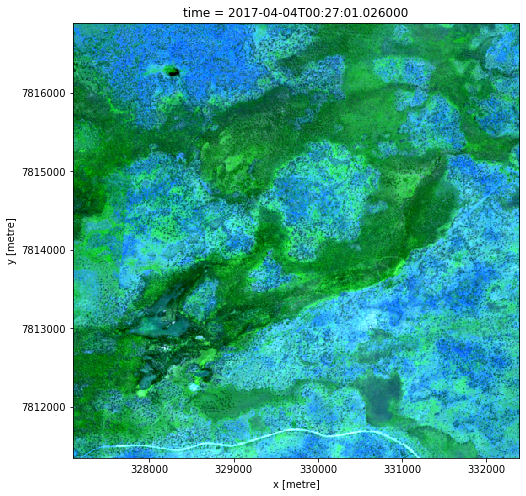

In [10]:
# View the rgb image

ClearSentinel_ds[['nbar_blue','nbar_green', 'nbar_red']].isel(time=20).to_array().plot.imshow(robust=True, figsize=(8,8))

#Neils original code: (which doesn't take out cloud)
#ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(6,6))


Our study area is the margin of a sandy, unconfined aquifer system to the south and mud flats to the north. In the middle of the area are a number of 'islands' of thick vegetation (dark green). We want to assess the likelihood of these communities having some degree of groudnwater water dependence.

In [11]:
# Calculate NDVI and NDMI

ndvi = ((ClearSentinel_ds.nbar_nir_1 - ClearSentinel_ds.nbar_red)/(ClearSentinel_ds.nbar_nir_1 + ClearSentinel_ds.nbar_red))
ndmi = ((ClearSentinel_ds.nbar_nir_1 - ClearSentinel_ds.nbar_swir_2)/(ClearSentinel_ds.nbar_nir_1 + ClearSentinel_ds.nbar_swir_2))
#Neils original code (not using cloud free):
#ndvi = ((ds.nir - ds.red)/(ds.nir + ds.red))


## Plotting NDVI

# Make a plot for each month

To investigate the difference in vegetation condition we plot the median and standard devation ndvi for each month


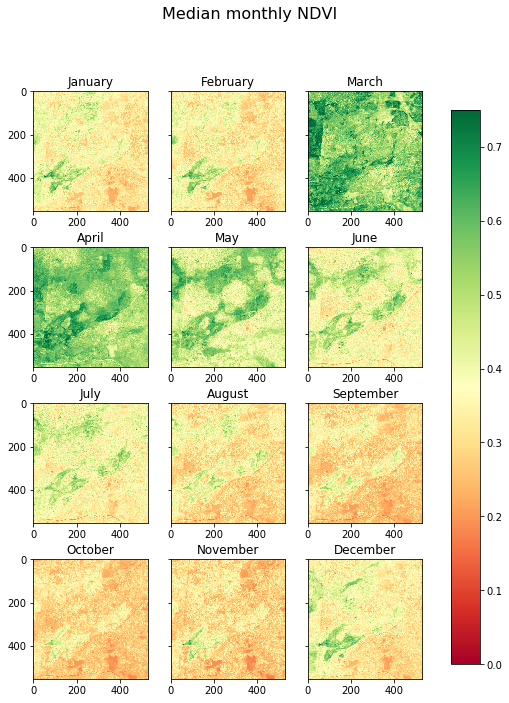

In [12]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': 0, 'vmax': 0.75}

fig.suptitle('Median monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndvi = ndvi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndvi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

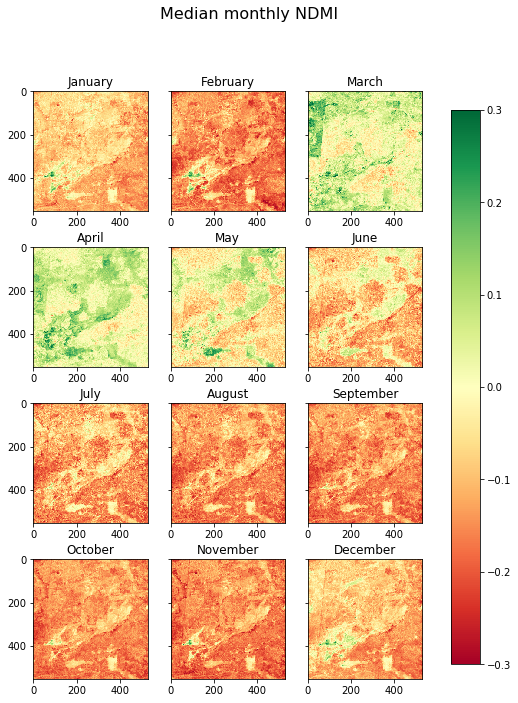

In [13]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': -0.30, 'vmax': 0.3}

fig.suptitle('Median monthly NDMI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndmi = ndmi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndmi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

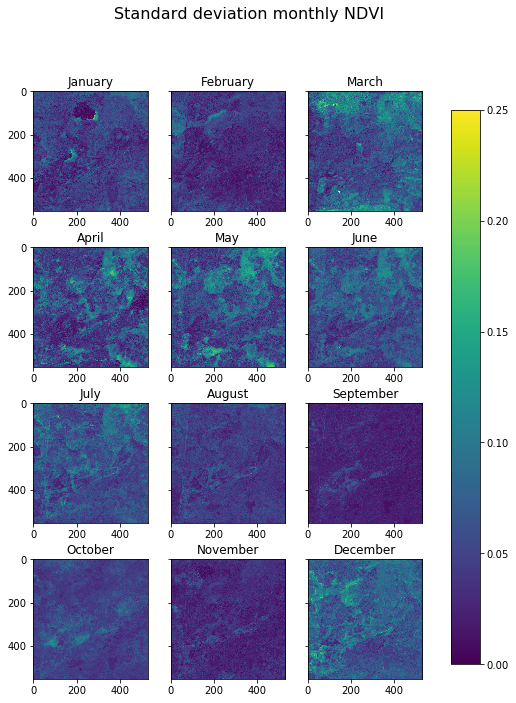

In [14]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.25}

fig.suptitle('Standard deviation monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndvi = ndvi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndvi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

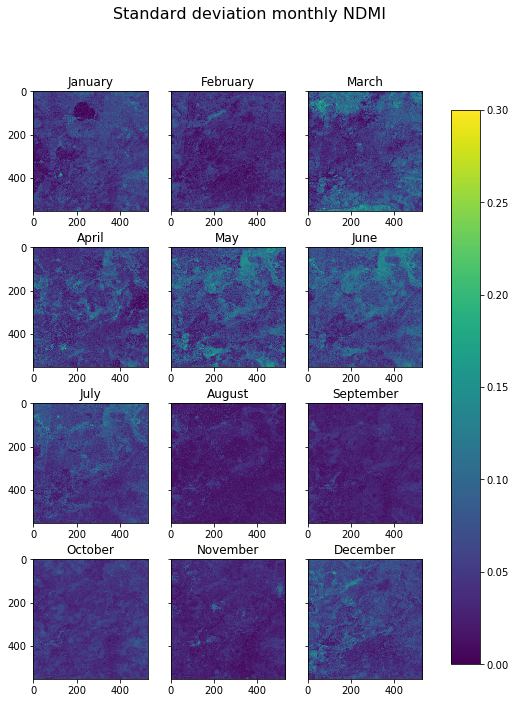

In [15]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.3}

fig.suptitle('Standard deviation monthly NDMI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndmi = ndmi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndmi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Run trend analysis

From the median plots it appears that the vegetation condition declines from about April until January. This is somewhat counter intuitive given that we expect rains in December January. The very high standard deviation in the wet months suggest we may be getting some influence of spurious measurements, perhaps from cloud shadow and/ or surface water.

From this we decide the best way to test vegetation is to use April to November. UB looking at figures, more July - November (so 7 - 11)

In [16]:
# We group the data by dry season for NDVI

#dry_months = [4,5,6,7,8,9,10,11]
dry_months = [5,6,7,8,9,10]

#REtrieve the dry months
ndvi_dry = ndvi[ndvi['time.month'].isin(dry_months)]
ndvi_dry = ndvi_dry.groupby('time.month').median(dim = 'time')


In [17]:
# We group the data by dry season for NDMI

#dry_months = [4,5,6,7,8,9,10,11]
dry_months = [5,6,7,8,9,10]

#REtrieve the dry months
ndmi_dry = ndmi[ndmi['time.month'].isin(dry_months)]
ndmi_dry = ndmi_dry.groupby('time.month').median(dim = 'time')


In [18]:
# Run the linear regression on the monthly ndvi
cov,cor,slope,intercept,pval,stderr = linregress_3D(ndvi_dry.month, ndvi_dry)

In [19]:
# Run the linear regression on the monthly ndmi
NDMIcov,NDMIcor,NDMIslope,NDMIintercept,NDMIpval,NDMIstderr = linregress_3D(ndmi_dry.month, ndmi_dry)

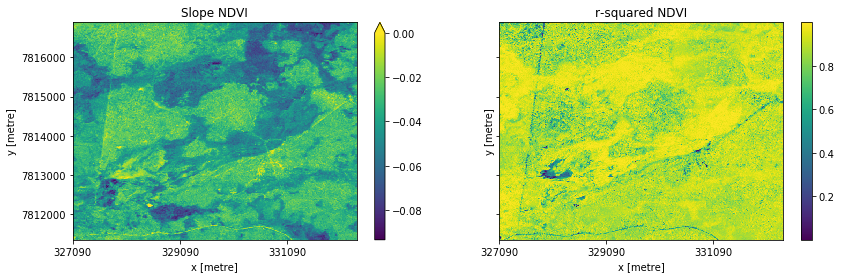

In [20]:
# View the slope and correlation coefficient for NDVI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


im1 = slope.plot(ax = ax1, vmin = slope.min(),
                vmax = 0.)
ax1.set_title('Slope NDVI')


r_squ = cor**2

im2 = r_squ.plot(ax = ax2)
ax2.set_title('r-squared NDVI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

From these plots it appears that most of the veg communities have a negative slope (i.e. declining NDVI/ vegetation condition). High r-squared values suggest a strong linear relationship in these areas. However there is a spring/vegetation at the bottom ~(327875,7813000) with a positive or small negative slope and a low-rsquared. We conclude that these communities retain their condition during the dry season and thus have a greater probability of groundwater dependence.

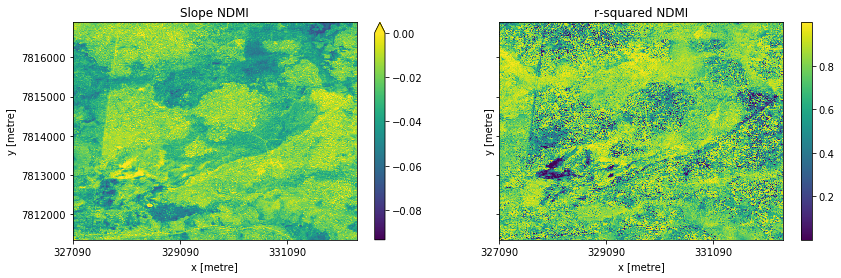

In [21]:
# View the slope and correlation coefficient for NDMI
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


NDMIim1 = NDMIslope.plot(ax = ax1, vmin = slope.min(),
                vmax = 0.)
ax1.set_title('Slope NDMI')


NDMIr_squ = NDMIcor**2

NDMIim2 = NDMIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDMI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

From these plots it appears that most of this area has a negative slope (i.e. declining NDMI/ moisture). High r-squared values suggest a strong linear relationship in these areas. However there is an area at the bottom ~(327875,7813000) with a positive or small negative slope and a low-rsquared. We conclude that this area retains moisture during the dry season and thus have a greater probability of influence from groundwater.

In [22]:
NDMIim1

In [23]:
savefilepath = '/home/547/pxk547/Images/'
print(f'your GeoTIFFs will write to {savefilepath}')
write_geotiff(savefilepath+'SSC.tif', ds.isel(time=0))
print(f'your GeoTIFFs was saved to {savefilepath}')

your GeoTIFFs will write to /home/547/pxk547/Images/


NameError: name 'write_geotiff' is not defined

In [1]:
# To illustrate this we plot the points and regression slope for NDVI

fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}


x,y = 326750 , 7816000   #spring that dries out near below spring
#x,y = 332830 , 7822345   #forest pocket that dries out above river

regression_pixel_drill_ndvi(x,y, ax1, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDVI recession = ', r_squ.sel(x = x, y = y,
                       method = 'nearest').values)

# Second pixel is in low recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}

#x,y = 327875,7813000  #spring that is generally wet/green most of the time
x,y = 328139,7812414

regression_pixel_drill_ndvi(x,y, ax1, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDVI recession = ', r_squ.sel(x = x, y = y,
                       method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDVI')

ax1.legend()



NameError: name 'plt' is not defined

R-squared for high dry season NDMI recession =  0.9573153869737204
R-squared for low dry season NDMI recession =  0.09187177379837057


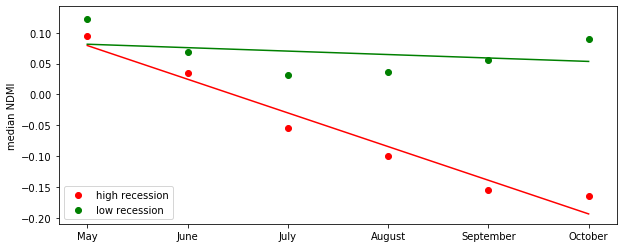

In [27]:
# To illustrate this we plot the points and regression slope for NDMI (but can't get it working - is doing it for NDVI)

fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}

x,y = 326750 , 7816000   #spring that dries out near below spring
#x,y = 332830 , 7822345   #forest pocket that dries out above river

regression_pixel_drill_ndmi(x,y, ax1, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDMI recession = ', NDMIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

# Second pixel is in low recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}

x,y = 327875,7813000  #spring that is generally wet/green most of the time

regression_pixel_drill_ndmi(x,y, ax1, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDMI recession = ', NDMIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDMI')

ax1.legend()



In [25]:
ax1.get_xticks()

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

## Conclusion

Our conclusion from this investigation is that there are vegetation communities in the area of interest that appear to that show statistically negligible change in condition despite prolonged dry conditions. In contrast, adjacent vegetation communities decline linearly throughout the dry season as soil moisture becomes scarce. We hypothesise that the lack of recession is due to the availability of groundwater within the root zones throughout the dry season. Follow up work including field observations and chemistry are required to validate this.